In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("LaLiga_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [4]:
data['total_seconds'] = data['minute'] * 60 + data['second']

In [5]:
def calculate_ttrp(data):
    data['TTRP'] = np.nan
    preceding_action_types = ['Aerial', 'BallRecovery', 'Tackle', 'TakeOn', 'Interception', 'Pass']
    relevant_actions = data[data['type'].isin(preceding_action_types)].copy()
    relevant_actions.sort_values(by=['gameId', 'total_seconds'], inplace=True)
    relevant_actions['prev_total_seconds'] = relevant_actions.groupby('gameId')['total_seconds'].shift(1)
    relevant_actions['prev_type'] = relevant_actions.groupby('gameId')['type'].shift(1)
    relevant_actions['prev_playerId'] = relevant_actions.groupby('gameId')['playerId'].shift(1)
    passes = data[data['type'] == 'Pass'].copy()
    passes = passes.merge(relevant_actions[['gameId', 'playerId', 'total_seconds', 'prev_total_seconds', 'prev_type', 'prev_playerId']],
                          how='left', on=['gameId', 'playerId', 'total_seconds'])
    passes['TTRP'] = np.where(
        ((passes['prev_type'] == 'Pass') & (passes['prev_playerId'] != passes['playerId'])) |
        ((passes['prev_type'] != 'Pass') & (passes['prev_playerId'] == passes['playerId'])),
        passes['total_seconds'] - passes['prev_total_seconds'],
        np.nan
    )
    data = data.merge(passes[['gameId', 'playerId', 'total_seconds', 'TTRP']], 
                      how='left', on=['gameId', 'playerId', 'total_seconds'], 
                      suffixes=('', '_y'))
    data['TTRP'] = data['TTRP'].combine_first(data['TTRP_y'])
    data.drop(columns=['TTRP_y'], inplace=True)
    return data

# Apply the function to your dataset
data = calculate_ttrp(data)


data_passes_succ = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful') & (data['x'] <= 119.2)]
data_passes_unsucc = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Unsuccessful') & (data['x'] <= 119.2)]

# Filter passes made within 2 seconds
data_passes_succ_within_2s = data_passes_succ[data_passes_succ['TTRP'] <= 2]
data_passes_unsucc_within_2s = data_passes_unsucc[data_passes_unsucc['TTRP'] <= 2]



In [6]:
# Assuming 'data' has already been loaded and preprocessed, including TTRP calculations

# Filter passes made within 2 seconds
#data_passes_succ_within_2s = data_passes_succ[data_passes_succ['TTRP'] <= 2]
#data_passes_unsucc_within_2s = data_passes_unsucc[data_passes_unsucc['TTRP'] <= 2]

# Identify progressive passes among successful passes within 2 seconds
data_passes_succ_within_2s['beginning'] = np.sqrt(np.square(120 - data_passes_succ_within_2s['x']) + np.square(40 - data_passes_succ_within_2s['y']))
data_passes_succ_within_2s['end'] = np.sqrt(np.square(120 - data_passes_succ_within_2s['endX']) + np.square(40 - data_passes_succ_within_2s['endY']))
data_passes_succ_within_2s['progressive'] = (data_passes_succ_within_2s['end'] / data_passes_succ_within_2s['beginning']) < 0.75

# Aggregate statistics for each player
player_stats = data_passes_succ_within_2s.groupby(['playerId', 'player', 'team']).agg(
    successful_passes_within_2s=('outcomeType', lambda x: (x == 'Successful').sum()),
    progressive_passes_within_2s=('progressive', 'sum')
).reset_index()

# Calculate total passes within 2 seconds
total_passes_succ_within_2s = data_passes_succ_within_2s.groupby('playerId').size().reset_index(name='total_passes_within_2s')
total_passes_unsucc_within_2s = data_passes_unsucc_within_2s.groupby('playerId').size().reset_index(name='total_passes_within_2s')
total_passes_within_2s = pd.concat([total_passes_succ_within_2s, total_passes_unsucc_within_2s]).groupby('playerId').sum().reset_index()

# Merge the total passes with player stats
player_stats = player_stats.merge(total_passes_within_2s, on='playerId')

# Calculate passing accuracy for passes within 2 seconds
player_stats['passing_accuracy_within_2s'] = (player_stats['successful_passes_within_2s'] / player_stats['total_passes_within_2s']) * 100

# Calculate % of progressive passes
player_stats['progressive_passes_pct'] = (player_stats['progressive_passes_within_2s'] / player_stats['successful_passes_within_2s']) * 100

# Merge with player metadata (e.g., minutes played)
info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90

# Merge with the main dataframe
player_stats = pd.merge(player_stats, info, on=['player', 'team'], how='left')
player_stats = player_stats[(player_stats['90s'] >= 15) & (player_stats['position'] != 'GK')
                         & (player_stats['age'] <= 25)]

# Calculate progressive passes per 90
player_stats['progressive_passes_p90'] = player_stats['progressive_passes_within_2s'] / player_stats['90s']

player_stats = player_stats.drop_duplicates(subset=['player'])

# Select the top 12 players based on percentage of progressive passes

#player_stats = player_stats[player_stats['team'] == 'Liverpool']
top_12_df = player_stats.sort_values("progressive_passes_p90", ascending=False).head(12)


# Display the final dataframe
top_12_df


/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_15711/1695522634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes_succ_within_2s['beginning'] = np.sqrt(np.square(120 - data_passes_succ_within_2s['x']) + np.square(40 - data_passes_succ_within_2s['y']))
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_15711/1695522634.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes_succ_within_2s['end'] = np.sqrt(np.square(120 - data_passes_succ_within_2s['endX']) + np.squar

,playerId,player,team,successful_passes_within_2s,progressive_passes_within_2s,total_passes_within_2s,passing_accuracy_within_2s,progressive_passes_pct,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,progressive_passes_p90
236,302889.0,Pepelu,Valencia,1013,126,1268,79.889590,12.438302,617,25,DMC,3305,82.4,36.722222,3.431165
410,397469.0,Óscar Mingueza,Celta Vigo,695,104,887,78.354002,14.964029,741,25,"D(CR),M(R)",3004,80.9,33.377778,3.115846
428,402197.0,Pedri,Barcelona,585,44,672,87.053571,7.521368,646,21,AM(CL),1476,87.8,16.400000,2.682927
536,448209.0,Sergi Cardona,Las Palmas,844,80,1059,79.697828,9.478673,649,24,D(L),2816,82.5,31.288889,2.556818
341,367180.0,Thierry Correia,Valencia,422,59,581,72.633391,13.981043,733,25,"D(R),M(R)",2162,76.3,24.022222,2.456059
325,361993.0,Juan Miranda,Real Betis,408,49,530,76.981132,12.009804,715,24,D(L),1862,82.4,20.688889,2.368421
402,395242.0,Álex Baena,Villarreal,482,68,633,76.145340,14.107884,628,22,"AM(CL),FW",2599,78.5,28.877778,2.354752
362,374813.0,Manu Sánchez,Celta Vigo,248,42,352,70.454545,16.935484,817,23,"D(L),M(L)",1776,76.5,19.733333,2.128378
446,409467.0,Antonio Blanco,Deportivo Alaves,566,57,734,77.111717,10.070671,830,23,DMC,2437,77.9,27.077778,2.105047
310,349660.0,Manu Morlanes,Mallorca,387,35,461,83.947939,9.043928,892,25,DMC,1611,84.8,17.900000,1.955307


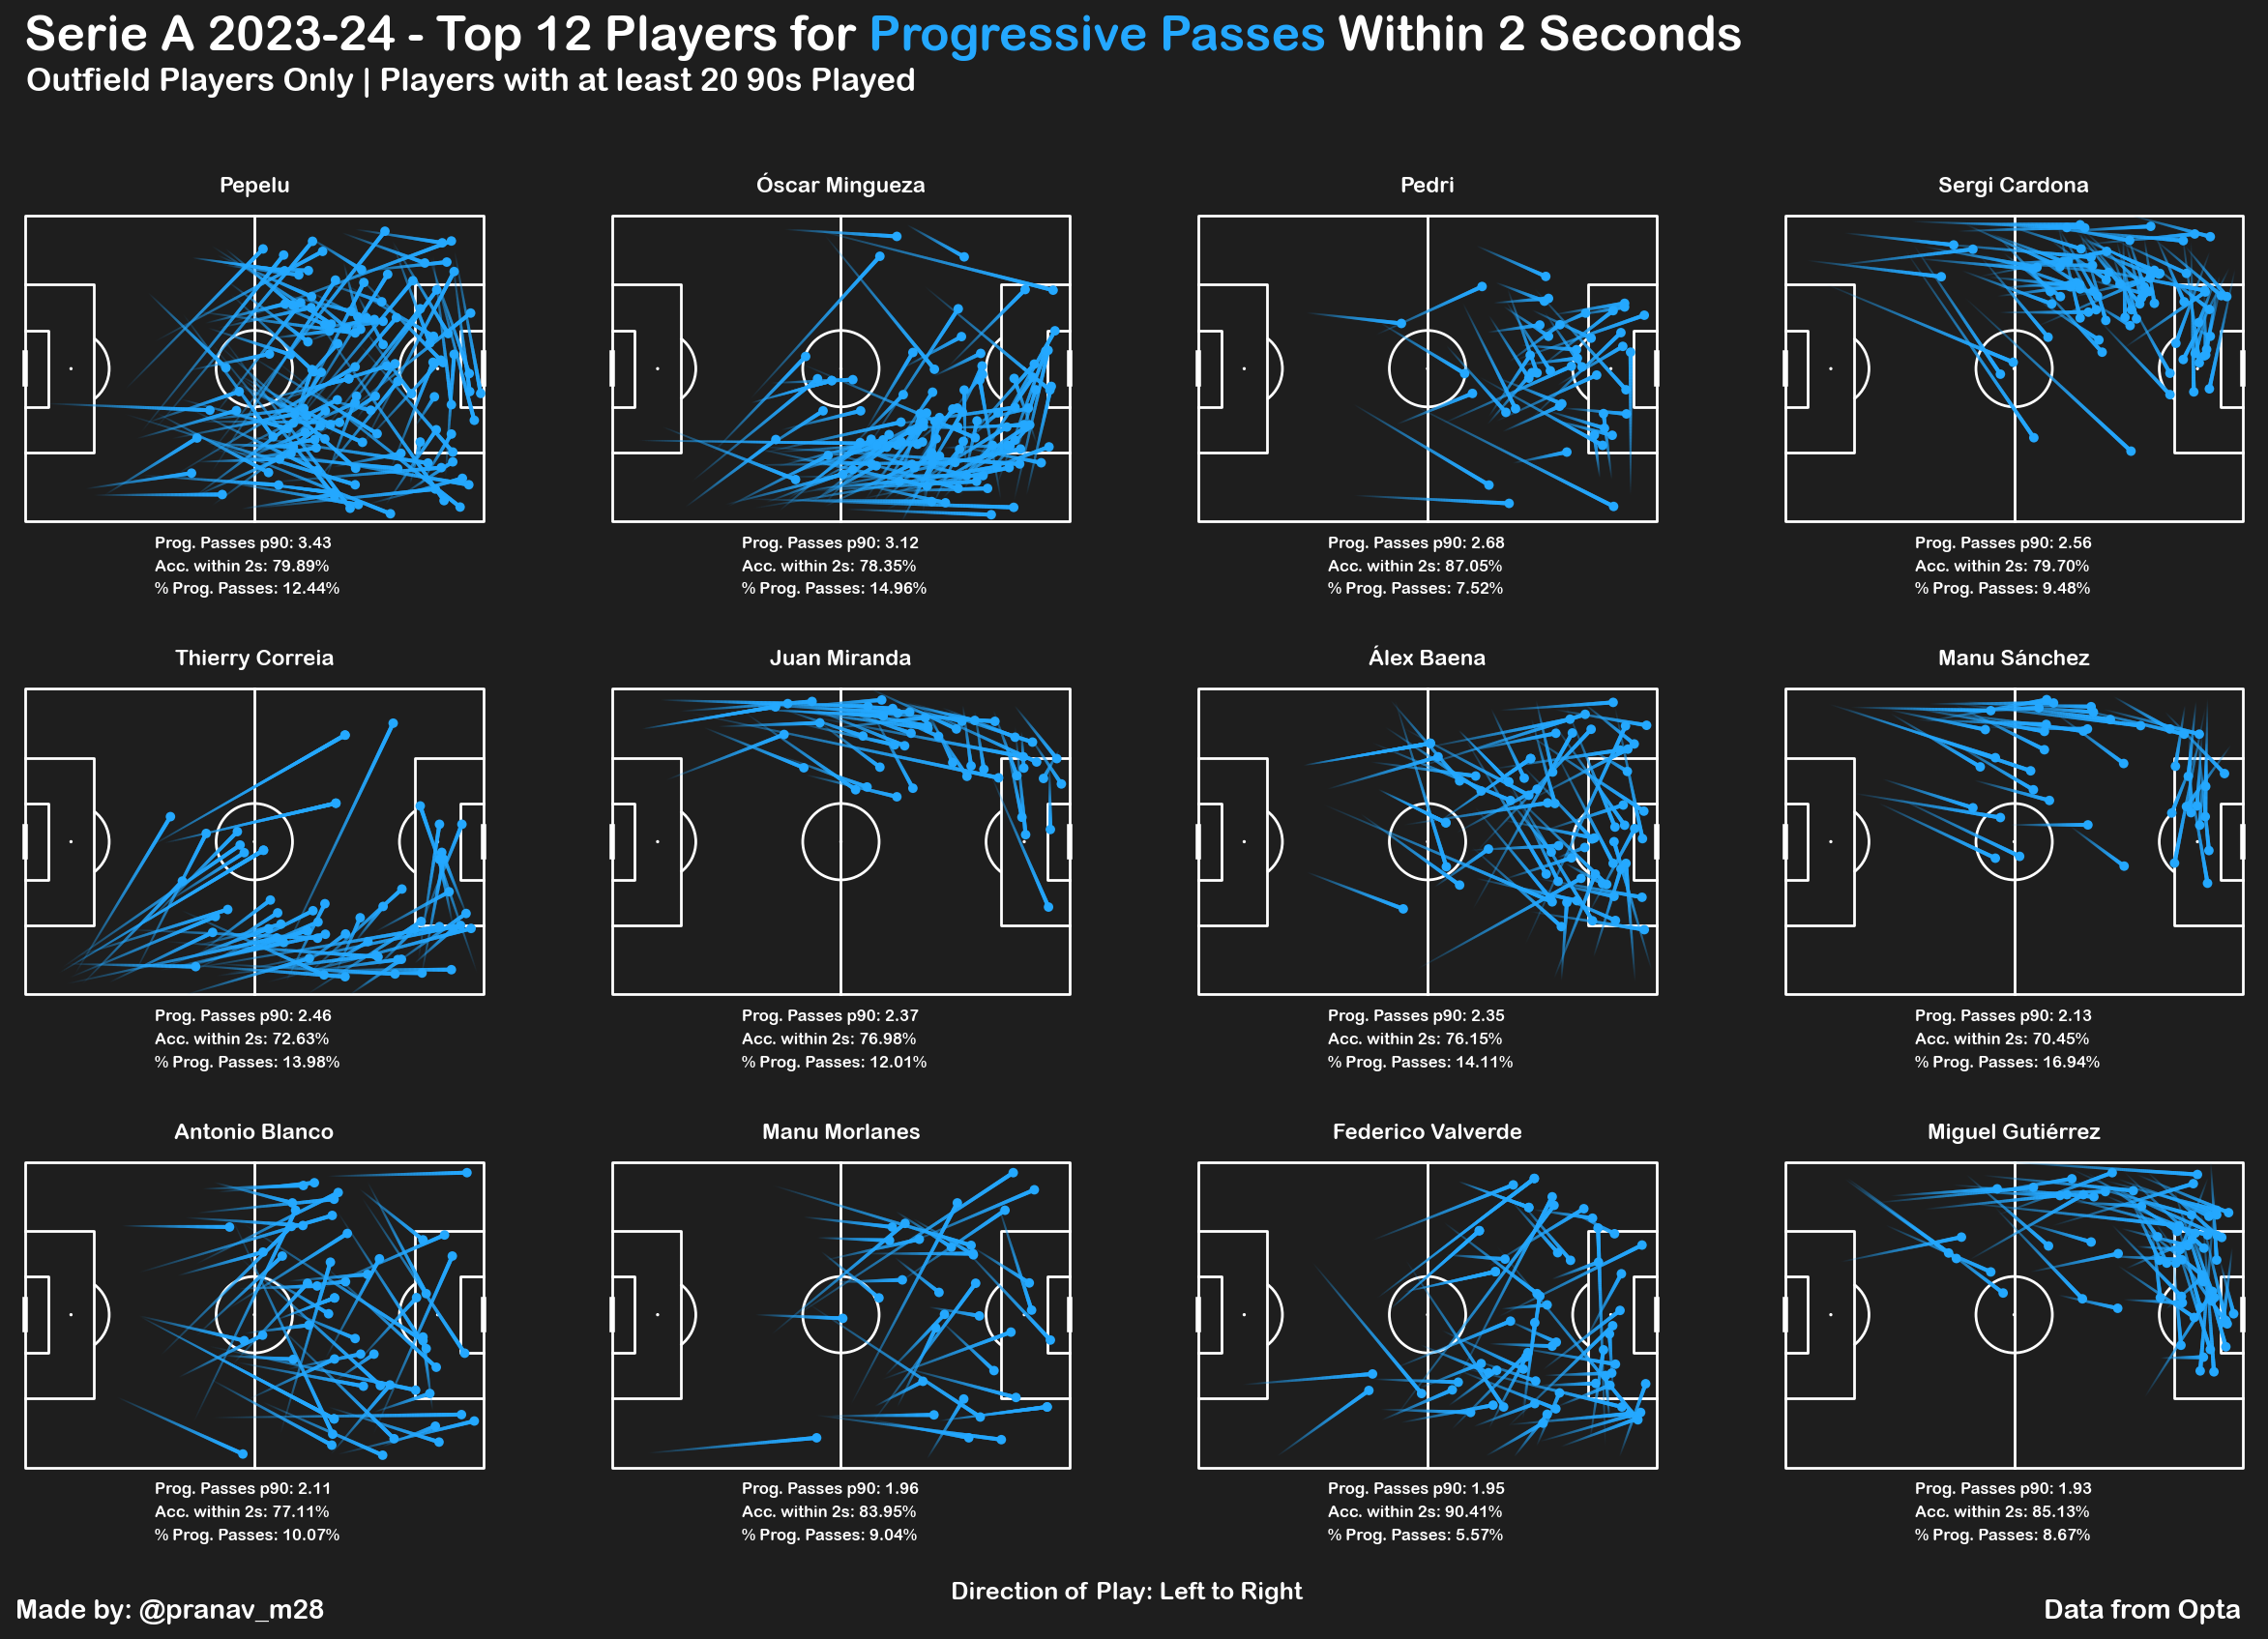

In [7]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from highlight_text import fig_text

# Define colors
pass_color = '#24a8ff'  # Progressive passes color
success_color = '#86dc3d'  # Successful passes color

fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

# Define the title and additional text
fig_text(0.426, 0.97, "Serie A 2023-24 - Top 12 Players for <Progressive Passes> Within 2 Seconds", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold'
        , highlight_textprops=[{"color": '#24a8ff'}])
#fig_text(0.21, 0.97, "<Progressive Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#24a8ff'}])
fig_text(0.284, 0.94, "Outfield Players Only | Players with at least 20 90s Played", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=24, fontweight='bold')

for ax, (_, player_data) in zip(axs.flatten(), top_12_df.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    
    # Filter data for the current player
    player_passes_succ_within_2s = data_passes_succ_within_2s[data_passes_succ_within_2s['playerId'] == player_id]
    player_passes_unsucc_within_2s = data_passes_unsucc_within_2s[data_passes_unsucc_within_2s['playerId'] == player_id]
    player_total_passes_within_2s = pd.concat([player_passes_succ_within_2s, player_passes_unsucc_within_2s])
    player_progressive_passes = player_passes_succ_within_2s[player_passes_succ_within_2s['progressive']]  # Only progressive passes

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot Progressive Passes
    pitch.lines(player_progressive_passes['x'], player_progressive_passes['y'], player_progressive_passes['endX'], player_progressive_passes['endY'],
                lw=3, transparent=True, comet=True, color=pass_color, ax=ax)
    pitch.scatter(player_progressive_passes['endX'], player_progressive_passes['endY'], s=50, marker='o', edgecolors='none', c=pass_color, ax=ax, alpha=1)
    
    # Plot Successful Passes (for color differentiation)
    #successful_passes = player_total_passes_within_2s[player_total_passes_within_2s['outcomeType'] == 'Successful']
    #pitch.lines(successful_passes['x'], successful_passes['y'], successful_passes['endX'], successful_passes['endY'],
     #           lw=2, transparent=False, color=success_color, ax=ax, ls='dashed')
    #pitch.scatter(successful_passes['endX'], successful_passes['endY'], s=50, marker='o', edgecolors='none', c=success_color, ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    # Add text below the pitch
    ax.text(34, -19, f'% Prog. Passes: {player_data["progressive_passes_pct"]:.2f}%', color='#FFFFFF', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(34, -13, f'Acc. within 2s: {player_data["passing_accuracy_within_2s"]:.2f}%', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=12, ha='left')
    ax.text(34, -7, f'Prog. Passes p90: {player_data["progressive_passes_p90"]:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=12, ha='left')

fig_text(0.18, 0.06, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.86, 0.06, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(
    0.510, 0.070, "Direction of Play: Left to Right", font='Arial Rounded MT Bold' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


#plt.savefig("TTRP LT2 SERIE_A.png", dpi=300, bbox_inches='tight')
plt.show()




In [8]:
player_stats_disp = player_stats[(player_stats['90s'] >= 15)]

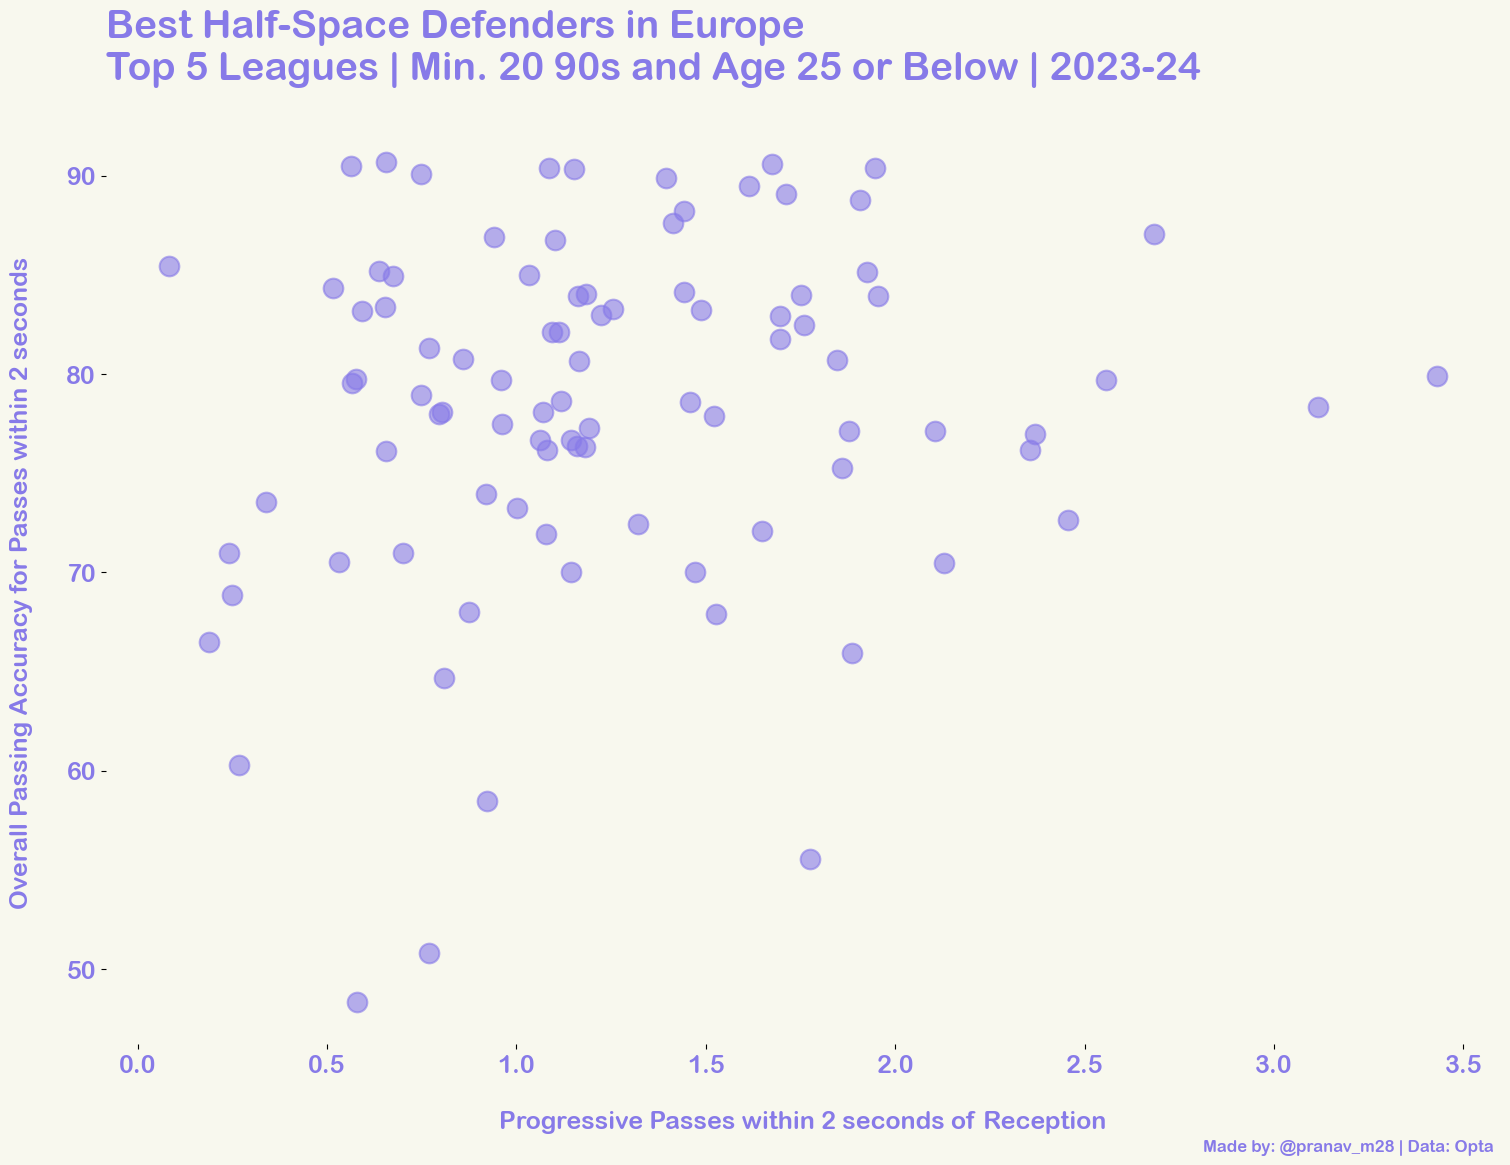

In [9]:
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(figsize=(18, 12))
fig.patch.set_facecolor('#f8f8ee')
ax.set_facecolor('#f8f8ee')

plot = plt.scatter(player_stats_disp['progressive_passes_p90'], player_stats_disp['passing_accuracy_within_2s'], color='#877ae8', s=200, alpha=0.6, linewidth=1.5)

# Set the title and labels with custom color
ax.text(0.0, 1.12, 'Best Half-Space Defenders in Europe\nTop 5 Leagues | Min. 20 90s and Age 25 or Below | 2023-24', 
        font='Arial Rounded MT Bold', fontsize=28, color='#877ae8', ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel('Progressive Passes within 2 seconds of Reception', font='Arial Rounded MT Bold', fontsize=18, color='#877ae8', labelpad=24)
ax.set_ylabel('Overall Passing Accuracy for Passes within 2 seconds', font='Arial Rounded MT Bold', fontsize=18, color='#877ae8', labelpad=24)

# Set the font properties for player names and percentage labels
font_prop = FontProperties(family='Arial Rounded MT Bold', size=18)

# Add player names below each scatter point
#for i, row in filter_actions.iterrows():
 #   if row['ball_won_hs_p90'] > 1.5 and row['tack+int_hs_p90'] > 0.5:
  #      ax.text(row['ball_won_hs_p90'], row['tack+int_hs_p90'], row['player'], 
   #             ha='center', va='center', fontsize=12, color='#877ae8', fontproperties=font_prop)

# Remove the x-axis numbers and ticks, but keep the player names on the y-axis
ax.tick_params(bottom=True, labelbottom=True)
ax.xaxis.set_visible(True)  # This removes the x-axis numbers

# Customize the y-axis tick labels
for tick in ax.get_yticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')
    
# Customize the y-axis tick labels
for tick in ax.get_xticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')

# Remove the spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove only the left spine
ax.spines['left'].set_visible(False)

# Add text for author and data source on the bottom right corner
ax.text(0.995, -0.12, 'Made by: @pranav_m28 | Data: Opta', font='Arial Rounded MT Bold', color='#877ae8', fontsize=12,
        ha='right', va='bottom', transform=ax.transAxes)


#plt.text(1.73, 1.04, 'Joris Chotard', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.36, 0.20, 'Kevin Danso', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.03, 0.96, 'Buongiorno', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.53, 0.91, 'Manuel Ugarte', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.11, 0.89, 'Vinicius Souza', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.68, 0.82, 'Samú Costa', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.45, 0.80, 'Loïc Badé', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.10, 0.79, 'Morten Frendrup', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.18, 0.56, 'Schlotterbeck', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.11, 0.62, 'Lamine Camara', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.05, 0.67, 'Anton Stach', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.94, 0.72, 'Danilo', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.84, 0.67, 'Pepelu', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.76, 0.74, 'Reitz', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.85, 0.55, 'Calafiori', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.80, 0.30, 'Lacroix', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.79, 0.63, 'Lopy', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.76, 0.49, 'Fofana', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.91, 0.39, 'Tapsoba', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.12, 0.73, 'Eric Martel', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(1.52, 0.63, 'Éderson', font='Arial Rounded MT Bold', size=15, color='#877ae8')

#plt.savefig("Half-Space Defenders Scatter Plot.png" , dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [10]:
player_stats_disp

,playerId,player,team,successful_passes_within_2s,progressive_passes_within_2s,total_passes_within_2s,passing_accuracy_within_2s,progressive_passes_pct,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,progressive_passes_p90
232,301019.0,Jules Koundé,Barcelona,943,52,1054,89.468691,5.514316,648,25,D(CR),2899,90.8,32.211111,1.614350
236,302889.0,Pepelu,Valencia,1013,126,1268,79.889590,12.438302,617,25,DMC,3305,82.4,36.722222,3.431165
252,317541.0,Brahim Díaz,Real Madrid,321,19,370,86.756757,5.919003,613,24,"AM(CLR),FW",1553,87.1,17.255556,1.101095
279,333048.0,Jørgen Strand Larsen,Celta Vigo,274,8,398,68.844221,2.919708,663,24,FW,2889,70.1,32.100000,0.249221
282,333182.0,Jorge Cuenca,Villarreal,390,37,477,81.761006,9.487179,722,24,D(CL),1963,84,21.811111,1.696383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,463838.0,Fermín López,Barcelona,331,19,394,84.010152,5.740181,744,21,AM(C),1446,85,16.066667,1.182573
562,474267.0,Iker Muñoz,Osasuna,442,34,613,72.104405,7.692308,765,21,DMC,1855,76.2,20.611111,1.649596
565,480249.0,Lamine Yamal,Barcelona,404,43,490,82.448980,10.643564,606,16,AM(R),2200,84.1,24.444444,1.759091
576,497564.0,Samu Omorodion,Deportivo Alaves,137,4,206,66.504854,2.919708,922,20,FW,1922,72.5,21.355556,0.187305
